## 1. Ground truth model
Credits:

- Author: Gabin Rousseau
- Code source: predominantly https://github.com/Schumacher-group/cellcircuits

In [1]:
#Imports

#params
import numpy as np

#analysis
from scipy.optimize import fsolve
from scipy.integrate import odeint

#main
import matplotlib.pyplot as plt

In [2]:
#Parameters
#Define Constants
lambda1 = 0.9  # proliferation rate of mF in 1/day
lambda2 = 0.8  #  proliferation rate of M in 1/day
mu1 = 0.3      #       removal rate of mF in 1/day
mu2 = 0.3      #        removal rate of M in 1/day
K = 10 ** 6    #  carrying capacity of mF in cells/ml
k1 = 10 ** 9   #  binding affinity of CSF in molecules/ml
k2 = 10 ** 9   # binding affinity of PDGF in molecules/ml


# converted from paper to match units min -> day
beta1  = 470 * 60 * 24 #    max secretion rate of CSF by mF in molecules/(cell * day) 
beta2  = 70 * 60 * 24  #    max secretion rate of PDGF by M in molecules/(cell * day)
beta3  = 240 * 60 * 24 #   max secretion rate of PDGF by mF in molecules/(cell * day)
alpha1 = 940 *60 * 24  #   max endocytosis rate of CSF by M in molecules/(cell * day)
alpha2 = 510 * 60 * 24 # max endocytosis rate of PDGF by mF in molecules/(cell * day)
gamma  = 2             # degradation rate of growth factors in 1/day
A_0 = 10**6            #             incoming injury signal in cells/day

In [3]:
#analysis

#Define ODE system

#Outputs list of gradients, state encompasses concentrations for mF, M, CSF and PDGF as cells per ml
def myofib_macro(state): # outputs list of gradients
    
    mF, M, CSF, PDGF = state

    d_mF_dt = mF * (lambda1 * (PDGF / (k1 + PDGF)) * (1 - mF / K) - mu1)
    d_M_dt = M * (lambda2 * (CSF / (k2+CSF)) - mu2)
    d_CSF_dt = beta1 * mF - alpha1 * M * (CSF / (k2 + CSF)) - gamma * CSF
    d_PDGF_dt = beta2 * M + beta3 * mF - alpha2 * mF * (PDGF / (k1 + PDGF))- gamma * PDGF

    return [d_mF_dt, d_M_dt, d_CSF_dt, d_PDGF_dt]

#find steady state for CSF and PDGF given mF and M levels using the fast timescale 
def CSF_PDGF_steady(x):
    mF = x[0]
    M = x[1]
    
    #In case the number of macrophages drops below 0 (e.g. in the numerical integration) interpret it as 0
    if M < 0:
        M = 0
    if mF < 0:
        mF = 0

    # equation for steady CSF is -gamma*(CSF)**2 + CSF*(beta1*mF-alpha1*M-k2*gamma) + beta1*k2*mF
    # equation for steady PDGF is  -gamma*(PDGF)**2 + PDGF * (beta2*M + beta3*mF -alpha2 * mF- gamma * k1) +k1*(beta2*M+beta3*mF)
    
    c_CSF = np.array([-1*gamma, beta1*mF-alpha1*M-k2*gamma, beta1*k2*mF])
    c_PDGF = np.array([-1*gamma, beta2*M + beta3*mF -alpha2 * mF - gamma * k1, k1*(beta2*M+beta3*mF)])
    CSF_roots = np.roots(c_CSF)
    PDGF_roots = np.roots(c_PDGF)
    root_pairs = []
    for CSF_root in CSF_roots:
        for PDGF_root in PDGF_roots:
                if np.isreal(CSF_root) and np.isreal(PDGF_root) and PDGF_root >= 0 and CSF_root >= 0:
                    root_pairs.append(CSF_root)
                    root_pairs.append(PDGF_root)
    return(root_pairs)

#t parameter is necessary for using the odeint function from scipy.integrate
def mF_M_rates(state, t):
    mF, M = state
    CSF, PDGF = CSF_PDGF_steady([mF, M])
    d_mF_dt = mF * (lambda1 * ((PDGF)/(k1+PDGF))*(1-mF/K)-mu1)
    d_M_dt = M*(lambda2*(CSF/(k2 + CSF))- mu2)
    return [d_mF_dt, d_M_dt]

def nullcline_mF(mF):
    smF_PDGF = (mu1 * k1 *K) / (lambda1 * K - mu1 *K - mF *lambda1)
    smF_M = -1 / beta2 * (beta3 * mF - alpha2 * mF * smF_PDGF / (k1 + smF_PDGF) - gamma * smF_PDGF)
    return [mF, smF_M]

def nullcline_M(sM_mF):
    sM_CSF = (k2 * mu2) / (lambda2 - mu2)
    M = ((k2 + sM_CSF) / (alpha1 * sM_CSF)) * (beta1 * sM_mF - gamma * sM_CSF)
    return [sM_mF, M]

def nulldiff(x):
    return nullcline_M(x)[1] - nullcline_mF(x)[1]

# finds intersection of nullclines, bad first estimate
def intersectionNull_bad(mFM_space):
    mF_list = []
    for i in range(len(mFM_space) - 1):
        if nulldiff(mFM_space[i]) * nulldiff(mFM_space[i + 1]) < 0 or nulldiff(mFM_space[i]) == 0:
            mF_list.append(mFM_space[i])
    return mF_list


def unstable_fixed_point_hotfibrosis_mF_M(mFM_space):
    #use intersection_Null_bad to make a first rough approximation of the fixed points
    fixed_point_mF_bad = intersectionNull_bad(mFM_space)
    fixed_point_M_bad = [nullcline_M(i)[1] for i in fixed_point_mF_bad]

    unstable_guess = fixed_point_mF_bad[0]
    hotfibrosis_guess = fixed_point_mF_bad[1]

    #Now use fsolve function to get a more precise solution and make it a floating number (instead of array)
    unstable_fixed_point_mF = fsolve(nulldiff, unstable_guess)[0]

    hotfibrosis_mF = fsolve(nulldiff, hotfibrosis_guess)[0]

    #find mF_M concentration at unstable fixed point
    unstable_fixed_point_mF_M = nullcline_mF(unstable_fixed_point_mF)

    #find mF_M concentrations at hotfibrosis point
    hotfibrosis_mF_M = nullcline_mF(hotfibrosis_mF)
    

    return (unstable_fixed_point_mF_M, hotfibrosis_mF_M)

def cold_fibr():
    # Set M = 0 in eqn 4, use eqn 1. solve system for PDGF, get a cubic

    PDGF_coeff = np.array([-gamma,
                           (K / lambda1) * (lambda1 - mu1) * (beta3 - alpha2) - gamma * k1,
                           (K * k1 / lambda1) * (beta3 * lambda1 - 2 * mu1 * beta3 + mu1 *alpha2),
                           -k1**2 * mu1 * K * beta3 / lambda1])
    # rearranged from eqns in transparent methods
    coldPDGF = np.roots(PDGF_coeff)
    coldmF = []
    
    for coldroot in coldPDGF:
        if np.isreal(coldroot) and coldroot >= 0:
            coldmF.append(K * ((lambda1 - mu1) / (lambda1) - (mu1 * k1) / (lambda1 * np.real(coldroot)))) # finds mF value given PDGF value
    
    return coldmF


#calculate separatrix
#outputs reverse derivative, state encompasses mF, M concentrations 
def myofib_macro_ODE_reverse(state, t):
    
    #checking if concentrations are in a reasonable range
    return [-d for d in mF_M_rates(state, t)] if all(0 <= x <= 10**7 for x in state) else [0, 0]

def calculate_separatrix(unstable_fixed_point_mF_M, t_separatrix):
    eps = 1e-6
    separatrix_left = odeint(myofib_macro_ODE_reverse, [unstable_fixed_point_mF_M[0] - eps,
                                                        unstable_fixed_point_mF_M[1] + eps], t_separatrix)
    separatrix_right = odeint(myofib_macro_ODE_reverse, [unstable_fixed_point_mF_M[0] + eps,
                                                         unstable_fixed_point_mF_M[1] - eps], t_separatrix)
    return np.array(separatrix_left), np.array(separatrix_right)


#streamlines analysis

# finds steady CSF and PDGF levels for given mF and M levels numerically from the steady state equations
def CSF_PDGF_steady_array(x):
    mF = x[0]
    M = x[1]
    # equation for steady CSF is -gamma*(CSF)**2 + CSF*(beta1*mF-alpha1*M-k2*gamma) + beta1*k2*mF
    # equation for steady PDGF is  -gamma*(PDGF)**2 + PDGF * (beta2*M + beta3*mF -alpha2 * mF- gamma * k1) +k1*(beta2*M+beta3*mF)

    c_CSF_array = np.array([-1*gamma*np.ones(np.shape(mF)), beta1*mF-alpha1*M-k2*gamma, beta1*k2*mF])
    c_PDGF_array = np.array([-1*gamma*np.ones(np.shape(mF)), beta2*M + beta3*mF -alpha2 * mF - gamma * k1, k1*(beta2*M+beta3*mF)])
    # define empty arrays fo CSF and PDGF
    CSF_array = np.zeros(np.shape(mF)) #is an array of the form [[][]]
    PDGF_array = np.zeros(np.shape(mF))
    for i in range(0, np.shape(mF)[0]):
        for j in range(0, np.shape(mF)[1]):
            # get 1d arrays of CSF and PDGF coefficients for each grid value
            c_CSF = np.array([c_CSF_array[0][i][j], c_CSF_array[1][i][j], c_CSF_array[2][i][j]])
            c_PDGF = np.array([c_PDGF_array[0][i][j], c_PDGF_array[1][i][j], c_PDGF_array[2][i][j]])
            CSF_roots = np.roots(c_CSF)
            PDGF_roots = np.roots(c_PDGF)
            for CSF_root in CSF_roots:
                for PDGF_root in PDGF_roots:
                    if np.isreal(CSF_root) and np.isreal(PDGF_root) and PDGF_root >= 0 and CSF_root >= 0:
                        CSF_array[i][j] = CSF_root
                        PDGF_array[i][j] = PDGF_root
    return [CSF_array, PDGF_array] 

def mF_M_rates_array(exp_mF, exp_M):
    # we need dmFdt and dMdt to be plotted at different values as streamplot can only take in linearly spaced values,
    # so we take in the exponents of mF and M values to get logarithmically spaced
    mF = 10**exp_mF
    M = 10**exp_M
    CSF, PDGF = CSF_PDGF_steady_array([mF, M])
    d_mF_dt = mF * (lambda1 * ((PDGF)/(k1+PDGF))*(1-mF/K)-mu1)
    d_M_dt = M*(lambda2*(CSF/(k2 + CSF))- mu2)
    return d_mF_dt, d_M_dt

In [4]:
#plotting
def plot_nullclines_fixed_points_separatrix(mFM_space, mFnull1, mFnull2, mFnull3, xsmooth, ysmooth, t_separatrix):
    plt.figure()
    plt.plot(nullcline_M(mFM_space)[0], nullcline_M(mFM_space)[1], 'r', label = 'Macrophage nullcline')

    plt.plot(nullcline_mF(mFnull1)[0], nullcline_mF(mFnull1)[1], 'b', label = 'Myofibroblast nullcline')
    plt.plot(nullcline_mF(mFnull2)[0], nullcline_mF(mFnull2)[1], 'b')
    plt.plot(nullcline_mF(mFnull3)[0], nullcline_mF(mFnull3)[1], 'b')
    plt.plot(xsmooth, ysmooth, 'b')


    plt.xlabel('Myofibroblasts')
    plt.ylabel('Macrophages')
    plt.xlim(1, 10**7)
    plt.ylim(1, 10**7)
    plt.xscale('log')
    plt.yscale('log')

    unstable_fixed_point_mF_M, hotfibrosis_mF_M = unstable_fixed_point_hotfibrosis_mF_M(mFM_space)

    coldfibrosis_mF_M = [cold_fibr()[0], 1]
    fixed_point_end_of_separatrix = [cold_fibr()[1], 1]

    plt.annotate('unstable fixed point', unstable_fixed_point_mF_M)
    plt.annotate('hot fibrosis fixed point', hotfibrosis_mF_M)
    plt.annotate('cold fibrosis fixed point', coldfibrosis_mF_M)

    plt.plot(unstable_fixed_point_mF_M[0], unstable_fixed_point_mF_M[1], marker = 'o', color = 'black')
    plt.plot(hotfibrosis_mF_M[0], hotfibrosis_mF_M[1], marker = 'o', color = 'black')
    plt.plot(coldfibrosis_mF_M[0], coldfibrosis_mF_M[1], marker = 'o', color = "black")
    plt.plot(fixed_point_end_of_separatrix[0], fixed_point_end_of_separatrix[1], marker = 'o', color = 'black')


    separatrix_left, separatrix_right = calculate_separatrix(unstable_fixed_point_mF_M, t_separatrix)
    plt.plot(separatrix_left[:, 0], separatrix_left[:, 1], 'black', label = 'Separatrix')
    plt.plot(separatrix_right[:, 0],separatrix_right[:, 1], 'black')

    plt.legend()


def plot_streamlines(mFM_space, t_separatrix):
    fig = plt.figure()
    mF_mesh = np.linspace(0, 7, 30)
    M_mesh = np.linspace(0, 7, 30)
    mF_stream, M_stream = np.meshgrid(mF_mesh, M_mesh)

    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    mF_rate, M_rate = mF_M_rates_array(mF_stream, M_stream)

    #scale the rates to appropriate size
    mF_rate_scaled = mF_rate/(10**mF_stream)
    M_rate_scaled = M_rate/(10**M_stream)

    strm = ax.streamplot(mF_stream, M_stream, mF_rate_scaled, M_rate_scaled,
                     color = (np.sqrt((mF_rate_scaled)**2 + (M_rate_scaled)**2)) , cmap = 'autumn')

    unstable_fixed_point_mF_M, hotfibrosis_mF_M = unstable_fixed_point_hotfibrosis_mF_M(mFM_space)

    
    separatrix_left, separatrix_right = calculate_separatrix(unstable_fixed_point_mF_M, t_separatrix)
    

    coldfibrosis_mF_M = [cold_fibr()[0], 1]
    fixed_point_end_of_separatrix = [cold_fibr()[1], 1]

    ax.set_xlim(0, 7)
    ax.set_ylim(0,7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_xlabel('myofibroblasts')
    ax2.set_ylabel('macrophages')


    ax2.plot(separatrix_left[:, 0], separatrix_left[:, 1], 'black')
    ax2.plot(separatrix_right[:, 0], separatrix_right[:, 1], 'black')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1, 10**7)
    ax2.set_ylim(1, 10**7)
    ax2.plot(unstable_fixed_point_mF_M[0], unstable_fixed_point_mF_M[1], marker = 'o', color = 'black')
    ax2.plot(hotfibrosis_mF_M[0], hotfibrosis_mF_M[1], marker = 'o', color = 'black')
    ax2.plot(coldfibrosis_mF_M[0], coldfibrosis_mF_M[1], marker = 'o', color = "black")
    ax2.plot(fixed_point_end_of_separatrix[0], fixed_point_end_of_separatrix[1], marker = 'o', color = 'black')

In [5]:
#main
def main():
    #time vectors 
    t_trajectory = np.linspace(0, 100, 10001)
    t_separatrix = np.linspace(0, 800, 1000)

    #Initial mF and M concentration
    x_initial = [1,1]

    #Nullcline parameters for plotting
    mFM_space = np.logspace(0, 7, 10**4)

    #Between those intervalls the nullcline for mF has poles, so we smooth those out  
    mFnull1 = np.logspace(0, 5.7, 10**3)
    mFnull2 = np.logspace(5.85, 5.95, 10**3)
    mFnull3 = np.logspace(6.05, 7, 10**3)


    # straight lines to replace/ignore the sharp increase near the poles
    xsmooth = [10**5.7, 10**5.85]
    ysmooth = [nullcline_mF(pt)[1] for pt in xsmooth]

    plot_nullclines_fixed_points_separatrix(mFM_space, mFnull1, mFnull2, mFnull3, xsmooth, ysmooth, t_separatrix = t_separatrix)

    plot_streamlines(mFM_space, t_separatrix)
    #Depict the plots
    plt.show()

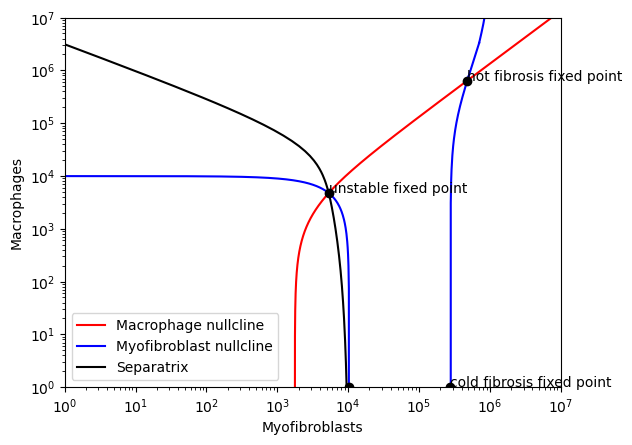

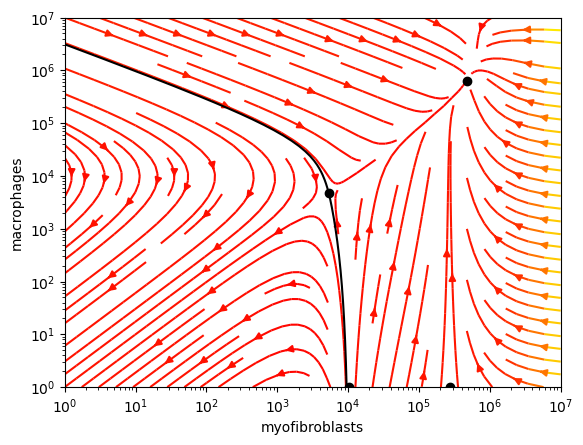

In [6]:
#Run main and plot phase portrait
main()

# 2. Simulation of cell distribution data biased by predefined model of division/death

In [40]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [31]:
# parameters
cells=["mF","M"] #cell type list

n=100 #steps for stochastic proliferation

x_boundaries=(0,2500) #tissue size x boundaries in microns
y_boundaries=(0,2500) #tissue size y boundaries in microns

r=80 #neighbourhood radius in microns, same as in Somer et al.

mF_rates=[0.066,0.049,0.030,0.013,0.00,-0.009,-0.015,-0.017] #division-death rate of mF based on #mF in neighbourhood
M_rates=[0.066,0.049,0.030,0.013,0.00,-0.009,-0.015,-0.017] #same but with M for #M neibourhood

In [20]:
# 1. Sample a random initial number of cells for each type
mF_num=round(np.random.uniform(1, 10000))
print(f"Number of mF cells chosen: {mF_num}.")
M_num=round(np.random.uniform(1, 10000))
print(f"Number of M cells chosen: {M_num}.")

Number of mF cells chosen: 8712.
Number of M cells chosen: 5715.


In [42]:
# 2. Sample a random spatial position in the tissue for each cell.


def random_tissue(cells):
    cell_type=[]
    position_x=[]
    position_y=[]
    for cell in cells:
        cell_num=round(np.random.uniform(1, 10000))
        print(f"Number of {cell} cells chosen: {cell_num}.")
        for i in range(0, cell_num):
            cell_type.append(f"{cell}")
            position_x.append(np.random.uniform(x_boundaries[0],x_boundaries[1]))
            position_y.append(np.random.uniform(y_boundaries[0],y_boundaries[1]))
    tissue=pd.DataFrame(list(zip(cell_type,position_x,position_y)), columns=["Cell_Type","X","Y"])
    
    # Get all spatial coordinates as array for query
    coordinates = tissue[['X', 'Y']].values
    
    for cell in cells:
        # Build KD-Trees for each cell
        tree = cKDTree(tissue[tissue['Cell_Type'] == cell][['X', 'Y']].values)
        #Search neihbourhood contents of the current cell type for all cells
        neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == cell else 0)
               for coords, cat in zip(coordinates, tissue['Cell_Type'])]
        column_name=f"#{cell}_neighbours"
        tissue[column_name] = neighbours
     
    return tissue

tissue=random_tissue(cells)
print(tissue.head())


Number of mF cells chosen: 3806.
Number of M cells chosen: 7243.
  Cell_Type            X            Y  #mF_neighbours  #M_neighbours
0        mF  1507.421214  2330.753092              13             33
1        mF   123.304393   566.724571              16             25
2        mF  1170.632264   581.488108              12             24
3        mF  1082.135986    18.062930               6             16
4        mF  1068.696503  1463.600040              11             25


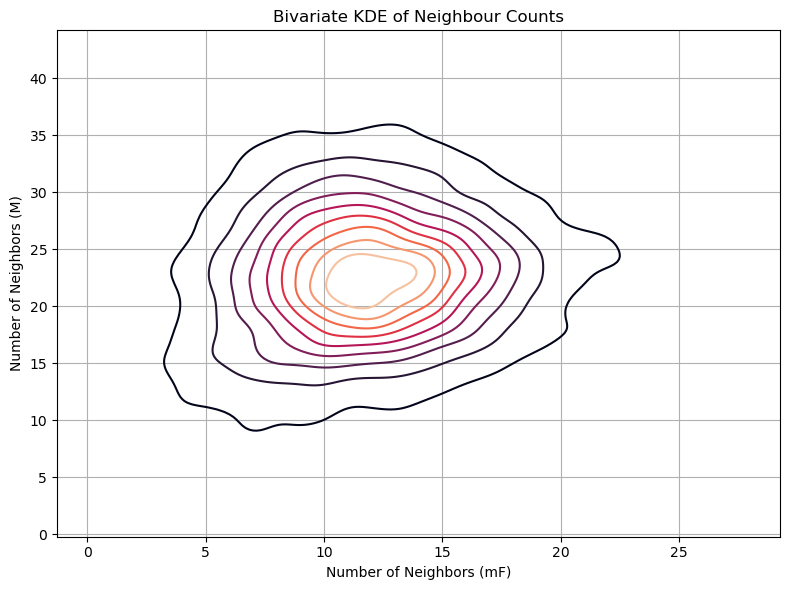

In [51]:
#Plot generated tissue with bivariate KDE method
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=tissue,
    x='#mF_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='rocket',
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts')
plt.xlabel('Number of Neighbors (mF)')
plt.ylabel('Number of Neighbors (M)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 3. stochastic biased proliferation over n steps

